In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
DATA_DIR = Path("data", "ijcnlp_dailydialog")

In [3]:
dialogues_text = pd.read_csv(Path(DATA_DIR, "dialogues_text.txt"),  delimiter = "\n", names = ["dialogues"])

dialogues_emotion = pd.read_csv(Path(DATA_DIR, "dialogues_emotion.txt"),  delimiter = "\n", names = ["emotion"])

dialogues_act = pd.read_csv(Path(DATA_DIR, "dialogues_act.txt"),  delimiter = "\n", names = ["act"])

data = pd.DataFrame.from_dict({"dialogues": dialogues_text["dialogues"], "emotion": dialogues_emotion["emotion"], "act": dialogues_act["act"]})

In [4]:
data

,dialogues,emotion,act
0,The kitchen stinks . __eou__ I'll throw out th...,2 0,3 4
1,"So Dick , how about getting some coffee for to...",4 2 0 1 0,3 4 3 1 1
2,Are things still going badly with your housegu...,0 1 0 0,2 1 3 4
3,Would you mind waiting a while ? __eou__ Well ...,0 0 0 4,3 2 1 1
4,Are you going to the annual party ? I can give...,0 4 4,3 4 1
...,...,...,...
13113,You have done an excellent job this year and w...,0 4 0 0 0 0 0 4,1 1 3 2 1 2 1 1
13114,Lindsay Tipping gave me your name as a referen...,0 4 0 0 0 0,1 1 2 1 2 1
13115,The consignments of chemical instruments have ...,0 0 0 6 0 0 0 0 0,3 2 1 2 1 3 3 3 4
13116,good morning . How can I help you ? __eou__ I'...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4,2 3 2 2 3 2 1 1 2 2 1 2 1 2 1 1 1


In [5]:
def seputterances(row):
    try:
        row = row.split("__eou__")
        row = row[:-1]
        return row
    except:
        return row

data["dialogues"] = data["dialogues"].apply(seputterances)

def sep_emotions_act(row):
    try:
        row = row.split(" ")
        row = row[:-1]
        return row
    except:
        return row

data["emotion"] = data["emotion"].apply(sep_emotions_act)
data["act"] = data["act"].apply(sep_emotions_act)

In [6]:
def num_turns(row):
    return len(row)

data["num_turns"] = data["dialogues"].apply(num_turns)

In [87]:
data

,dialogues,emotion,act,num_turns
0,"[The kitchen stinks . , I'll throw out the ga...","[2, 0]","[3, 4]",2
1,"[So Dick , how about getting some coffee for t...","[4, 2, 0, 1, 0]","[3, 4, 3, 1, 1]",5
2,[Are things still going badly with your houseg...,"[0, 1, 0, 0]","[2, 1, 3, 4]",4
3,"[Would you mind waiting a while ? , Well , ho...","[0, 0, 0, 4]","[3, 2, 1, 1]",4
4,[Are you going to the annual party ? I can giv...,"[0, 4, 4]","[3, 4, 1]",3
...,...,...,...,...
13113,[You have done an excellent job this year and ...,"[0, 4, 0, 0, 0, 0, 0, 4]","[1, 1, 3, 2, 1, 2, 1, 1]",8
13114,[Lindsay Tipping gave me your name as a refere...,"[0, 4, 0, 0, 0, 0]","[1, 1, 2, 1, 2, 1]",6
13115,[The consignments of chemical instruments have...,"[0, 0, 0, 6, 0, 0, 0, 0, 0]","[3, 2, 1, 2, 1, 3, 3, 3, 4]",9
13116,"[good morning . How can I help you ? , I'd li...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 3, 2, 2, 3, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, ...",17


In [57]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")

In [58]:
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-medium")

In [88]:
dataset = {"S1":[], "S2": []}


for i in range(len(data)):
    for j in range(len(data["dialogues"][i])):
        dataset["S1"].append(data["dialogues"][i][j])
        try:
            dataset["S2"].append(data["dialogues"][i][j+1])
        except:
            dataset["S2"].append(tokenizer.eos_token)

In [89]:
tokenizer.pad_token = tokenizer.eos_token

tokenized_dataset = tokenizer(
    dataset["S1"],
    dataset["S2"],
    padding=True,
    truncation=True,
    return_tensors = "pt"
)

tokenized_dataset.keys()

dict_keys(['input_ids', 'attention_mask'])

In [90]:
outputs = model(**tokenized_dataset, labels = tokenized_dataset["input_ids"])

: 

: 

In [ ]:
outputs

CausalLMOutputWithCrossAttentions(loss=tensor(7.6549, grad_fn=<NllLossBackward0>), logits=tensor([[[ -36.2874,  -35.0113,  -38.0793,  ...,  -40.5163,  -41.3759,
           -34.9193],
         [ -72.1520,  -73.0176,  -78.8572,  ...,  -80.8325,  -77.2209,
           -75.0334],
         [ -67.9686,  -65.8994,  -70.4752,  ...,  -81.4254,  -72.8403,
           -67.3824],
         ...,
         [ -94.2072,  -86.9492,  -89.7964,  ..., -107.1431, -108.0931,
           -94.2349],
         [ -94.1488,  -86.8903,  -89.7301,  ..., -107.0797, -108.0366,
           -94.1952],
         [ -94.0234,  -86.7656,  -89.5930,  ..., -106.9436, -107.9056,
           -94.0898]],

        [[ -41.7623,  -41.7778,  -44.8669,  ...,  -49.2863,  -46.8294,
           -42.0784],
         [-158.1525, -158.5062, -163.3547,  ..., -167.2552, -166.5898,
          -159.5356],
         [-109.3378, -110.3345, -114.9972,  ..., -114.1525, -119.1261,
          -111.9324],
         ...,
         [ -96.9935,  -89.8131,  -92.3633, 

<AxesSubplot:>

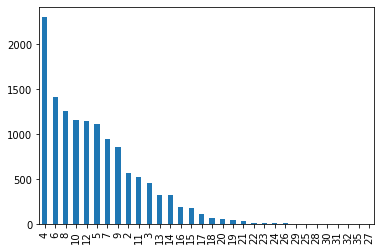

In [238]:
data["num_turns"].value_counts().plot(kind="bar")

In [239]:
data["num_turns"].describe()

count    13118.000000
mean         7.850282
std          3.986789
min          2.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         35.000000
Name: num_turns, dtype: float64

<BarContainer object of 7 artists>

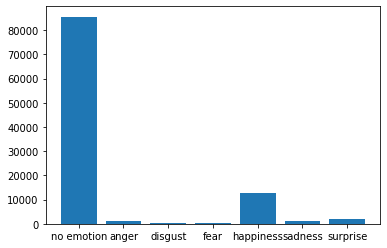

In [240]:
EMOTION_MAPPER = { 0: "no emotion", 1: "anger", 2: "disgust", 3: "fear", 4: "happiness", 5: "sadness", 6: "surprise"}

emotions = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}

def emotion_counter(row):
    for emotion in row:
        emotions[int(emotion)]+=1

data["emotion"].apply(emotion_counter)

emotions = {EMOTION_MAPPER[k]:v for k,v in emotions.items()}

plt.bar(emotions.keys(), emotions.values())

<BarContainer object of 4 artists>

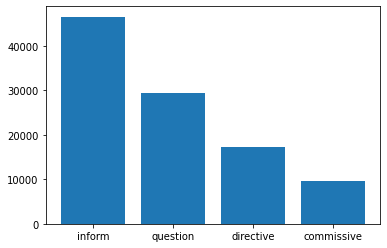

In [224]:
ACT_MAPPER = { 1: "inform", 2: "question", 3: "directive", 4: "commissive" }

acts = { 1: 0, 2: 0, 3: 0, 4: 0 }

def act_counter(row):
    for act in row:
        acts[int(act)]+=1

data["act"].apply(act_counter)

acts = {ACT_MAPPER[k]:v for k,v in acts.items()}

plt.bar(acts.keys(), acts.values())

In [225]:
def tokenizer(row):
    dialogue_tokens = []
    for dialogues in row:
        tokens = dialogues.split()
        dialogue_tokens.append(tokens)

    return dialogue_tokens


data["tokens"] = data["dialogues"].apply(tokenizer)

In [226]:
data

,dialogues,emotion,act,num_turns,tokens
0,"[The kitchen stinks . , I'll throw out the ga...","[2, 0]","[3, 4]",2,"[[The, kitchen, stinks, .], [I'll, throw, out,..."
1,"[So Dick , how about getting some coffee for t...","[4, 2, 0, 1, 0]","[3, 4, 3, 1, 1]",5,"[[So, Dick, ,, how, about, getting, some, coff..."
2,[Are things still going badly with your houseg...,"[0, 1, 0, 0]","[2, 1, 3, 4]",4,"[[Are, things, still, going, badly, with, your..."
3,"[Would you mind waiting a while ? , Well , ho...","[0, 0, 0, 4]","[3, 2, 1, 1]",4,"[[Would, you, mind, waiting, a, while, ?], [We..."
4,[Are you going to the annual party ? I can giv...,"[0, 4, 4]","[3, 4, 1]",3,"[[Are, you, going, to, the, annual, party, ?, ..."
...,...,...,...,...,...
13113,[You have done an excellent job this year and ...,"[0, 4, 0, 0, 0, 0, 0, 4]","[1, 1, 3, 2, 1, 2, 1, 1]",8,"[[You, have, done, an, excellent, job, this, y..."
13114,[Lindsay Tipping gave me your name as a refere...,"[0, 4, 0, 0, 0, 0]","[1, 1, 2, 1, 2, 1]",6,"[[Lindsay, Tipping, gave, me, your, name, as, ..."
13115,[The consignments of chemical instruments have...,"[0, 0, 0, 6, 0, 0, 0, 0, 0]","[3, 2, 1, 2, 1, 3, 3, 3, 4]",9,"[[The, consignments, of, chemical, instruments..."
13116,"[good morning . How can I help you ? , I'd li...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 3, 2, 2, 3, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, ...",17,"[[good, morning, ., How, can, I, help, you, ?]..."


In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch


tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-medium")

# Let's chat for 5 lines
for step in range(5):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(bot_input_ids, max_length=1000, pad_token_id=tokenizer.eos_token_id)

    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))


/raid/cs18resch11003/anaconda3/envs/dialogpt/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: 100%|██████████| 823M/823M [00:27<00:00, 31.8MB/s] 


DialoGPT: 
DialoGPT: I'm good, how are you?
DialoGPT: I'm sorry, I'm not sure what to do.
DialoGPT: I can't, I'm sorry.
DialoGPT: I'm sorry, I'm not sure what to do.
